In [ ]:
import pandas as pd

# Load the data files
files = [
    #'2019c.csv',
    #'2020c.csv',
    #'2021c.csv',
    '2022c.csv',
    '2023c.csv',
    '2024c.csv'
]

# Read each CSV file
dataframes = [pd.read_csv(file) for file in files]

# Concatenate all dataframes into a single one
electricity_data = pd.concat(dataframes)

# Convert the 'Datetime' column to datetime format
electricity_data['Datetime'] = pd.to_datetime(electricity_data['Datetime'])

# Sort the data by Datetime in case it's not sorted
electricity_data = electricity_data.sort_values('Datetime')

# Extract time-based features
electricity_data['Year'] = electricity_data['Datetime'].dt.year
electricity_data['Month'] = electricity_data['Datetime'].dt.month
electricity_data['Day'] = electricity_data['Datetime'].dt.day
electricity_data['Hour'] = electricity_data['Datetime'].dt.hour
electricity_data['DayOfWeek'] = electricity_data['Datetime'].dt.weekday

# Add a lag feature (price from the previous time step)
electricity_data['Price_Lag1'] = electricity_data['USEP (c/kWh)'].shift(1)

# Add rolling window features (e.g., moving average of the last 6 hours)
electricity_data['Rolling_Mean_6h'] = electricity_data['USEP (c/kWh)'].rolling(window=12).mean()

# Drop any rows with NaN values created by the lag and rolling features
electricity_data_cleaned = electricity_data.dropna()

# Calculate daily mean and standard deviation
electricity_data_cleaned['Daily_Mean'] = electricity_data_cleaned.groupby(electricity_data_cleaned['Datetime'].dt.date)['USEP (c/kWh)'].transform('mean')
electricity_data_cleaned['Daily_Std'] = electricity_data_cleaned.groupby(electricity_data_cleaned['Datetime'].dt.date)['USEP (c/kWh)'].transform('std')

# Define a surge as when the price exceeds the daily mean plus 2 times the standard deviation
electricity_data_cleaned['Surge_ZScore'] = electricity_data_cleaned['USEP (c/kWh)'] > (electricity_data_cleaned['Daily_Mean'] + 2 * electricity_data_cleaned['Daily_Std'])



# Load the demand data from the provided Excel file
demand_data = pd.read_excel('demand_data_2022_onwards.xlsx')

# Try parsing the DATE column with more flexibility to handle both formats
demand_data['Datetime'] = pd.to_datetime(demand_data['DATE'], errors='coerce') + pd.to_timedelta((demand_data['PERIOD'] - 1) * 30, unit='m')

# Check for any issues during parsing (e.g., NaT values in Datetime)
demand_data[demand_data['Datetime'].isna()].head()

# Merge the demand data with the electricity price data
merged_data = pd.merge(electricity_data_cleaned, demand_data[['Datetime', 'DEMAND (MW)']], on='Datetime', how='left')



!pip install tensorflow scikit-learn pandas
# Import necessary libraries for LSTM model
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Prepare the features and target variables for LSTM
# Using 'USEP (c/kWh)', 'Price_Lag1', 'Rolling_Mean_6h', 'DEMAND (MW)' to predict 'Surge_ZScore'

# Drop rows with missing values in essential columns
clean_data = merged_data.dropna(subset=['USEP (c/kWh)', 'Price_Lag1', 'Rolling_Mean_6h', 'DEMAND (MW)', 'Surge_ZScore'])

# Select features and target
features = clean_data[['USEP (c/kWh)', 'Price_Lag1', 'Rolling_Mean_6h', 'DEMAND (MW)']]
target = clean_data['Surge_ZScore']

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Convert target to numpy array
target = target.values

# Create sequences of data for LSTM
def create_sequences(features, target, time_steps=12):
    X, y = [], []
    for i in range(time_steps, len(features)):
        X.append(features[i-time_steps:i])
        y.append(target[i])
    return np.array(X), np.array(y)

# Create sequences with a window of 12 timesteps
X, y = create_sequences(scaled_features, target, time_steps=12)

# Split data into training and testing sets (80% training, 20% testing)
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Build the LSTM model
model = Sequential()

# Add LSTM layers with Dropout to prevent overfitting
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1, activation='sigmoid'))  # Sigmoid activation for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Summarize the model
model.summary()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

test_loss, test_accuracy


<ipython-input-32-93020e792d8b>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  electricity_data_cleaned['Daily_Mean'] = electricity_data_cleaned.groupby(electricity_data_cleaned['Datetime'].dt.date)['USEP (c/kWh)'].transform('mean')
<ipython-input-32-93020e792d8b>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  electricity_data_cleaned['Daily_Std'] = electricity_data_cleaned.groupby(electricity_data_cleaned['Datetime'].dt.date)['USEP (c/kWh)'].transform('std')
<ipython-input-32-93020e792d8b>:46: Settin

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1148/1148 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.9624 - loss: 0.1888 - val_accuracy: 0.9605 - val_loss: 0.1565
Epoch 2/10
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.9648 - loss: 0.1417 - val_accuracy: 0.9605 - val_loss: 0.1370
Epoch 3/10
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.9641 - loss: 0.1351 - val_accuracy: 0.9609 - val_loss: 0.1333
Epoch 4/10
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.9652 - loss: 0.1284 - val_accuracy: 0.9612 - val_loss: 0.1377
Epoch 5/10
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.9643 - loss: 0.1224 - val_accuracy: 0.9617 - val_loss: 0.1227
Epoch 6/10
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.9643 - loss: 0.1204 - val_accuracy: 0.9618 - val_loss: 0.1180
Epoch 7/10
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.9649 - loss: 0.1153 - val_accuracy: 0.9623 - val_loss: 0.1220
Epoch 8/10
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.9659 - loss: 0.11

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 12, 50)              │          11,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,755 (366.23 KB)

 Trainable params: 31,251 (122.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,504 (244.16 KB)

287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9573 - loss: 0.1223


(0.11841294914484024, 0.9627572894096375)

In [ ]:
# Make predictions using the test set
y_pred = model.predict(X_test)

y_pred_binary = (y_pred > 0.5).astype(int)

# Adjust the decision threshold to 0.3
threshold = 0.45
y_pred_binary_adjusted = (y_pred > threshold).astype(int)

# Evaluate performance with the adjusted threshold
from sklearn.metrics import classification_report
print("Classification report with classical threshold:")
print(classification_report(y_test, y_pred_binary))
print("Classification report with adjusted threshold:")
print(classification_report(y_test, y_pred_binary_adjusted))

287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Classification report with classical threshold:
              precision    recall  f1-score   support

       False       0.97      1.00      0.98      8820
        True       0.65      0.13      0.21       363

    accuracy                           0.96      9183
   macro avg       0.81      0.56      0.60      9183
weighted avg       0.95      0.96      0.95      9183

Classification report with adjusted threshold:
              precision    recall  f1-score   support

       False       0.97      0.99      0.98      8820
        True       0.55      0.20      0.29       363

    accuracy                           0.96      9183
   macro avg       0.76      0.59      0.63      9183
weighted avg       0.95      0.96      0.95      9183



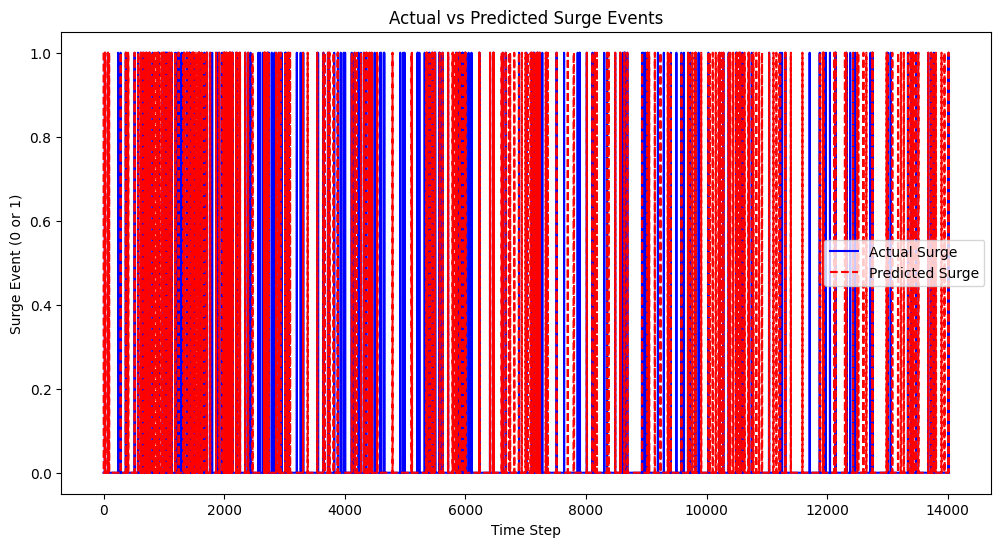

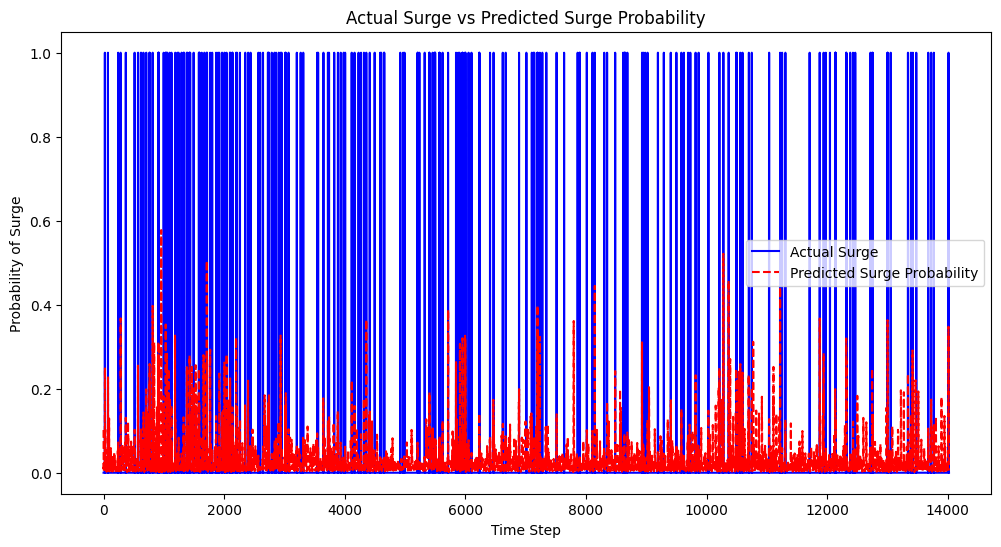

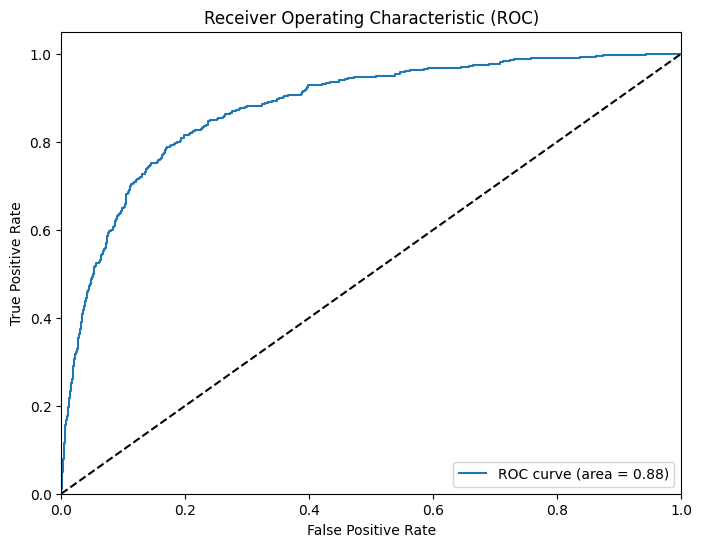

In [ ]:
# Since the output is a sigmoid (binary classification), convert the predictions to binary (1 or 0)
y_pred_binary = (y_pred > threshold).astype(int)

import matplotlib.pyplot as plt

# Plot the actual surge values vs the predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Surge', color='blue')
plt.plot(y_pred_binary, label='Predicted Surge', color='red', linestyle='dashed')
plt.title('Actual vs Predicted Surge Events')
plt.xlabel('Time Step')
plt.ylabel('Surge Event (0 or 1)')
plt.legend()
plt.show()

# Plot the actual surge values vs the predicted probabilities
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Surge', color='blue')
plt.plot(y_pred, label='Predicted Surge Probability', color='red', linestyle='dashed')
plt.title('Actual Surge vs Predicted Surge Probability')
plt.xlabel('Time Step')
plt.ylabel('Probability of Surge')
plt.legend()
plt.show()

from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Import necessary libraries
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

# Assuming your model has already been defined and data is preprocessed as `X_train`, `y_train`, `X_test`, `y_test`

### Step 1: Lower the Decision Threshold Further
# Make predictions on test data
y_pred = model.predict(X_test)

# Adjust the decision threshold to 0.2
threshold = 0.2
y_pred_binary_lower_threshold = (y_pred > threshold).astype(int)

# Evaluate performance with the new threshold
print("Classification report with lower threshold (0.08):")
print(classification_report(y_test, y_pred_binary_lower_threshold))


### Step 2: Apply SMOTE (Resampling the Data)
# Reshape X_train for SMOTE (since it requires 2D data)
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

# Apply SMOTE to oversample the minority class (surge events)
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, y_train)

# Reshape X_train back to 3D for LSTM
X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], X_train.shape[1], X_train.shape[2])

# Re-train the model on the resampled dataset
model.fit(X_train_resampled, y_train_resampled, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Make predictions on the test data
y_pred_smote = model.predict(X_test)

# Adjust threshold again to 0.2 for SMOTE data
y_pred_binary_smote = (y_pred_smote > threshold).astype(int)

# Evaluate performance after applying SMOTE
print("Classification report with SMOTE:")
print(classification_report(y_test, y_pred_binary_smote))


### Step 3: Use Class Weights
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

# Re-train the model with class weights
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), class_weight=class_weights_dict)

# Make predictions on the test set
y_pred_class_weights = model.predict(X_test)

# Apply the adjusted threshold of 0.08
y_pred_binary_class_weights = (y_pred_class_weights > threshold).astype(int)

# Evaluate performance with class weights applied
print("Classification report with class weights:")
print(classification_report(y_test, y_pred_binary_class_weights))


439/439 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Classification report with lower threshold (0.08):
              precision    recall  f1-score   support

       False       1.00      0.48      0.65     13617
        True       0.05      0.93      0.10       404

    accuracy                           0.49     14021
   macro avg       0.52      0.71      0.37     14021
weighted avg       0.97      0.49      0.63     14021

Epoch 1/10
3389/3389 ━━━━━━━━━━━━━━━━━━━━ 63s 17ms/step - accuracy: 0.8976 - loss: 0.2555 - val_accuracy: 0.8766 - val_loss: 0.2785
Epoch 2/10
3389/3389 ━━━━━━━━━━━━━━━━━━━━ 49s 14ms/step - accuracy: 0.9006 - loss: 0.2445 - val_accuracy: 0.8497 - val_loss: 0.3260
Epoch 3/10
3389/3389 ━━━━━━━━━━━━━━━━━━━━ 82s 14ms/step - accuracy: 0.9058 - loss: 0.2391 - val_accuracy: 0.8898 - val_loss: 0.2591
Epoch 4/10
3389/3389 ━━━━━━━━━━━━━━━━━━━━ 52s 15ms/step - accuracy: 0.9068 - loss: 0.2337 - val_accuracy: 0.8492 - val_loss: 0.3422
Epoch 5/10
3389/3389 ━━━━━━━━━━━━━━━━━━━━ 77s 14ms/st